In [1]:
import sys
import os
import cv2
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import torch
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models


In [2]:
sys.path.append('/home/edshkim98/shkim/pytorch-multi-class-focal-loss')
from focal_loss import *
# import EarlyStopping
from earlystopping import *

In [3]:
#SUMMARY 22/10/2020
#Libraries used: Pytorch, OpenCV, PIL, Matplotlib etc.
#Two cases: 1. Segmentation of seeps(classes=8) 2. Segmentation and classification of each class of seep(classes=2)
#Hugly Unbalanced dataset
#Tried to use an edge enhancement technique such as Laplacian kernel, but did not work out well.
#Main challenge was dealing with the unbalanced data

In [4]:
path = r'/home/edshkim98/shkim/data/'
torch.manual_seed(42)

In [5]:
def plot_img(img, mask):
    fig, ax = plt.subplots(1,2, figsize=(12,8))
    
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")

    plt.show()

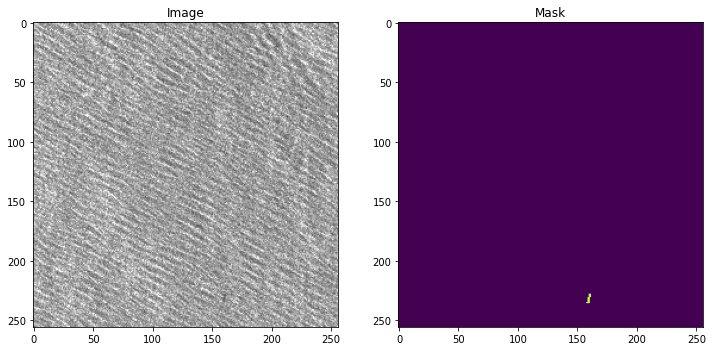

In [6]:
img_path = path+"seep_detection/train_images_256/"
mask_path = path+"seep_detection/train_masks_256/"

images = []
masks = []

for filename in os.listdir(img_path):
    images.append(cv2.cvtColor(cv2.imread(img_path + filename), cv2.COLOR_BGR2RGB))
    masks.append(plt.imread(mask_path + filename))

images = np.array(images)
masks = np.array(masks)

plot_img(images[1], masks[1])

In [7]:
dc = {}
for i in range(8):
    dc[i] = 0
dc

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}

In [8]:
lst = []
for i in os.listdir(path+"seep_detection/train_masks_256/"):
    img = Image.open(path+"seep_detection/train_masks_256/"+i)
    img = np.asarray(img)
    for j in np.unique(img):
        dc[j]+=1
    lst.append(np.unique(img))

In [9]:
dc

{0: 790, 1: 478, 2: 161, 3: 76, 4: 66, 5: 125, 6: 200, 7: 51}

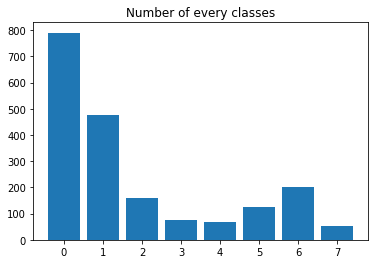

In [10]:
plt.bar(range(len(dc)), list(dc.values()), align='center')
plt.xticks(range(len(dc)), list(dc.keys()))
plt.title("Number of every classes")
plt.show()

In [11]:
from __future__ import print_function, division
from skimage import io, transform
from torchvision import transforms, utils
from torch.utils.data.dataset import random_split
import torchvision.transforms.functional as TF
import utils


train_transforms = transforms.Compose([
    transforms.ToTensor()
    #transforms.Normalize()
                    ])

class CustomDataset(Dataset):
    def __init__(self,path,val_files,transform = train_transforms, valid = False):
        self.path =path
        self.valid = valid
        self.files = []
        self.transforms = transform
        
        new_dir = self.path+'seep_detection/train_images_256/'
        new_dir2 = self.path+"seep_detection/train_masks_256/"
        
        self.total = os.listdir(new_dir)
        
        if self.valid: #if validation
            self.val_files = val_files
            for i in self.val_files:
                sample = {}
                img = cv2.imread(new_dir+str(i))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                #kernel = np.array([[-1,-1,-1], 
                #   [-1, 9,-1],
                #   [-1,-1,-1]])
                #img = cv2.filter2D(img, -1, kernel) # applying the sharpening kernel to the input image & displaying it.
                img = Image.fromarray(img)

                mask = cv2.imread(new_dir2+str(i))
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
                
                #for i in range((mask.shape[0])): #changing to binary classfication problem
                #    for j in range((mask.shape[1])):
                #        if mask[i][j] > 0:
                #            mask[i][j] = 1
                #        else:
                #            mask[i][j] = 0          
                
                mask = Image.fromarray(mask)

                sample['image'] = img
                sample['mask'] = mask
                self.files.append(sample)

        else:
            self.train = [i for i in self.total if i not in val_files]
            for i in self.train:
                sample = {}
                img = cv2.imread(new_dir+str(i))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                #kernel = np.array([[-1,-1,-1], 
                #   [-1, 9,-1],
                #   [-1,-1,-1]])
                #img = cv2.filter2D(img, -1, kernel) # applying the sharpening kernel to the input image & displaying it.
                img = Image.fromarray(img)
                
                mask = cv2.imread(new_dir2+str(i))
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
                
                #for i in range((mask.shape[0])): #changing to binary classfication problem
                #    for j in range((mask.shape[1])):
                #        if mask[i][j] > 0:
                #            mask[i][j] = 1
                #        else:
                #            mask[i][j] = 0
                
                mask = Image.fromarray(mask)
        
                sample['image'] = img
                sample['mask'] = mask
                self.files.append(sample)
              
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self,idx):
        x = self.files[idx]['image']
        y = self.files[idx]['mask']
        img = x
        mask = y
        if self.valid:
            pass
        else:
            # Random rotating
            if random.random() > 0.5:
                angle = random.randint(0,11)
                img = TF.rotate(img,angle)
                mask = TF.rotate(mask,angle)

            # Random horizontal flipping
            if random.random() > 0.5:
                img = TF.hflip(img)
                mask = TF.hflip(mask)

            # Random vertical flipping
            if random.random() > 0.5:
                img = TF.vflip(img)
                mask = TF.vflip(mask)
        
        if self.transforms:
            img = self.transforms(img)
        mask = np.asarray(mask)
        return {"image": img, "mask": mask.astype(int)}

In [12]:
batch_size = 16
x = os.listdir(path+'seep_detection/train_images_256/')

total = len(x)
train_num = int(total * 0.8)
val_num = int(total * 0.2)
if (train_num+val_num) < total:
    val_num += 1
print("total: ",total)
print("val+train: ",val_num+train_num)
print("train: ", train_num)
print("val: ", val_num)

def train_val_split(total, val_num):
    val = np.random.choice(len(total), val_num,replace=False)
    val_files = list(np.asarray(total)[val])
    train_files = [i for i in total if i not in val_files]
    
    return val,val_files,train_files

val,val_files,train_files = train_val_split(x, val_num)

train_dataset = CustomDataset(path,val_files, transform =train_transforms,valid = False)
val_dataset = CustomDataset(path, val_files,transform=train_transforms, valid=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last = True)

print('######### Dataset class created #########')
print('Number of images: ', total)
print('train size in no of batch: ',len(train_loader))
print("test size in no of batch: ",len(val_loader))
print('train size: ',len(train_loader)*batch_size)
print("test size: ",len(val_loader)*batch_size)

total:  790
val+train:  790
train:  632
val:  158
######### Dataset class created #########
Number of images:  790
train size in no of batch:  39
test size in no of batch:  9
train size:  624
test size:  144


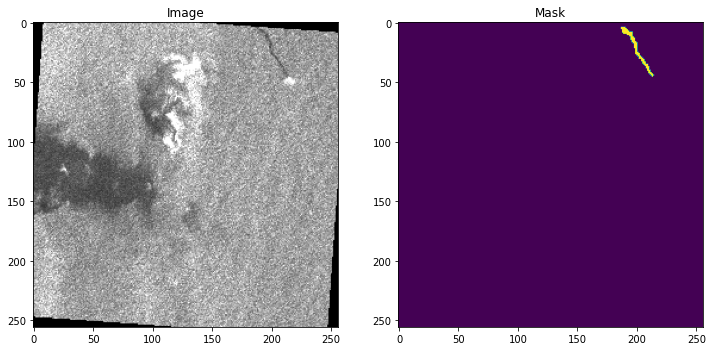

In [13]:
x = next(iter(train_loader))
x['image'][1].shape
plot_img(x['image'][3].permute(1,2,0), x['mask'][3])

In [14]:
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self,x):
        return x
    

In [15]:
class deeplabv3(nn.Module):
    def __init__(self,num_classes):
        super(deeplabv3, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet101(pretrained=True)
        self.model.classifier[-1] = nn.Conv2d(256,num_classes,1)
        self.model.aux_classifier = nn.Sequential(
            nn.Conv2d(1024, 256,3),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes,1)
        )
        for param in self.model.parameters(): #making all layers fine tuneable
            param.requires_grad = True

    def forward(self, inputs): # inputs.shape = samples x channels x height x width 
        outputs = self.model(inputs)
        return outputs
    

In [16]:
torch.cuda.set_device(0)
torch.cuda.device_count()
torch.cuda.current_device()

0

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
model = deeplabv3(num_classes=8)
model.to(device)

deeplabv3(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (

In [19]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("total number of parameters: ",pytorch_total_params)

total number of parameters:  60989776


In [20]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), 0.01)
batch_size

16

In [21]:
def dice_loss(true, logits, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

In [22]:
def one_hot(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes)
    return y[labels]

class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=8):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def forward(self, inputs, target_oneHot):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)

        # Numerator Product
        inter = inputs * target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N,self.classes,-1).sum(2)

        #Denominator 
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return -loss.mean()

In [23]:
def customized_loss(pred, label):
    weights = [0.05, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
    #weights = [0.1, 1.0]
    class_weights = torch.FloatTensor(weights).cuda()
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    celoss = criterion(pred, label)
    label_en = one_hot(label,8)#
    label_en = label_en.permute(0,3,1,2)
    label_en = label_en.to(device)
    iou = mIoULoss()(pred,label_en)
    dice = dice_loss(label,pred)

    
    return 0.5*celoss+1.5*iou+1.5*dice

In [24]:
def mIOU(label, pred, num_classes=8):
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    iou_list = list()
    present_iou_list = list()

    pred = pred.view(-1)
    label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        pred_inds = (pred == sem_class)
        target_inds = (label == sem_class)
        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else: 
            intersection_now = (pred_inds[target_inds]).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    return np.mean(present_iou_list)

In [25]:
def train(model,train_loader,valid_loader,epochs=100,alpha = 0.001, save=True):
    # initialize the early_stopping object
    patience = 8
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    loss_trend = []
    iou_trend = []
    best = 0
    for epoch in range(epochs):
        e = epoch
        model.train()
        for i, data in enumerate(train_loader):
            total = 0
            correct = 0
            inputs, labels = data['image'].type(torch.FloatTensor).to(device), data['mask'].to(device)
            output = model(inputs)
            _,pred = torch.max(output['out'].data,1)
            optimizer.zero_grad()
            
            loss = customized_loss(output['out'],labels)
            loss.backward()
            optimizer.step()
            total += labels.size(1) * labels.size(2) * 16
            correct += (pred == labels).sum().item()
            iou = mIOU(labels,output['out'])
                        
            if i%5 == 0:
                acc = 100. * correct/total
                print("Epoch: {}, Loss:{:.6f}, Accuracy:{:.6f}, mIOU:{}".format(epoch,loss.item(),acc,iou))#,np.mean(ious)))
            
        model.eval()
        total = 0
        correct =0
        loss =[]
        ious = []
        with torch.no_grad():  
            for i, data in enumerate(val_loader):
                inputs, labels = data['image'].type(torch.FloatTensor).to(device), data['mask'].to(device)
                output= model(inputs)                
                
                ls = customized_loss(output['out'],labels)
                loss.append(ls.item())
                _,pred = torch.max(output['out'].data,1) 

                total += labels.size(1) * labels.size(2)*16
                correct += (pred == labels).sum().item()
                iou = mIOU(labels,output['out'])
                ious.append(iou)


                
            acc = 100. * correct / total
            loss_final = np.mean(loss)
            loss_trend.append(loss_final)
            iou = np.mean(ious)
            iou_trend.append(iou)
            if iou > best:
                best = iou
            print("The validation accuracy: {:.6f} and the validation loss: {:.6f}, mIOU:{}".format(acc,loss_final,iou))
        
        # early_stopping needs the iou value to check if it has increased, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(1-iou, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            print("Best model iou: {}".format(best))
            break

    return loss_trend, iou_trend

In [26]:
loss, iou = train(model,train_loader, val_loader, save=True)

<ipython-input-22-9c28e13b6eb4>:29: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  inter = inputs * target_oneHot


Epoch: 0, Loss:2.497056, Accuracy:6.425381, mIOU:0.013480156589603578
Epoch: 0, Loss:1.643039, Accuracy:98.249245, mIOU:0.12281155586242676
Epoch: 0, Loss:1.822013, Accuracy:97.491837, mIOU:0.16248639424641928
Epoch: 0, Loss:1.524155, Accuracy:99.033546, mIOU:0.12379193305969238
Epoch: 0, Loss:1.574506, Accuracy:98.867702, mIOU:0.1412395749773298
Epoch: 0, Loss:1.495927, Accuracy:96.544838, mIOU:0.14375413292817427
Epoch: 0, Loss:1.738091, Accuracy:96.299076, mIOU:0.14035820269281646
Epoch: 0, Loss:1.721448, Accuracy:97.657299, mIOU:0.12207162380218506
The validation accuracy: 97.957908 and the validation loss: 10.881818, mIOU:0.1591233384672296
Validation loss decreased (inf --> 0.840877).  Saving model ...
Epoch: 1, Loss:1.878058, Accuracy:96.566200, mIOU:0.12070775032043457
Epoch: 1, Loss:1.619653, Accuracy:98.457527, mIOU:0.16409587860107422
Epoch: 1, Loss:1.544532, Accuracy:98.894024, mIOU:0.12361752986907959
Epoch: 1, Loss:1.473787, Accuracy:98.910904, mIOU:0.1413012913295201
Epo

Epoch: 11, Loss:1.305426, Accuracy:96.988487, mIOU:0.24876989152510173
Epoch: 11, Loss:1.327242, Accuracy:96.195412, mIOU:0.16438218097569732
The validation accuracy: 97.121694 and the validation loss: 1.385552, mIOU:0.21165180535514858
Validation loss decreased (0.823397 --> 0.788348).  Saving model ...
Epoch: 12, Loss:1.411424, Accuracy:96.157551, mIOU:0.17926689943433022
Epoch: 12, Loss:1.377599, Accuracy:95.520592, mIOU:0.18304589086967366
Epoch: 12, Loss:1.458027, Accuracy:94.058228, mIOU:0.13786517648195018
Epoch: 12, Loss:1.289413, Accuracy:96.731663, mIOU:0.1422465949356837
Epoch: 12, Loss:1.445803, Accuracy:96.263123, mIOU:0.17966702983279034
Epoch: 12, Loss:1.308825, Accuracy:95.168972, mIOU:0.16020206053598512
Epoch: 12, Loss:1.311039, Accuracy:95.983887, mIOU:0.16239996737770698
Epoch: 12, Loss:1.523430, Accuracy:96.613979, mIOU:0.1572673673564417
The validation accuracy: 94.786983 and the validation loss: 1.387297, mIOU:0.18607299091109575
EarlyStopping counter: 1 out of 8

In [44]:
#Best IoU for seg class = 8: 0.214
#Best IoU for seg class = 2: 0.668

[0.17959033121561818]

Text(0.5, 1.0, 'IoU for segmentation of seeps (class=2)')

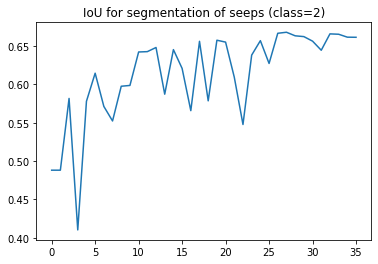

In [32]:
plt.plot(iou)
plt.title("IoU for segmentation of seeps (class=2)")

Text(0.5, 1.0, 'IoU for segmentation of seeps (class=8)')

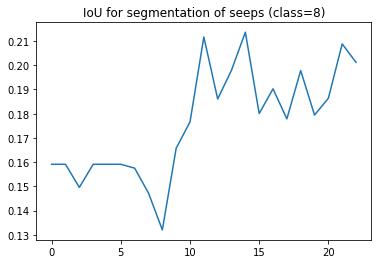

In [27]:
plt.plot(iou)
plt.title("IoU for segmentation of seeps (class=8)")

In [41]:
model = deeplabv3(num_classes=8)
model.to(device)
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()

model2 = deeplabv3(num_classes=2)
model2.to(device)
model2.load_state_dict(torch.load("checkpoint_seg2.pt"))
model2.eval()

deeplabv3(
  (model): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (

In [47]:

def plot_test_mask(img, true, pred, pred2, iou, iou2):
    fig, ax = plt.subplots(1,4, figsize=(16,8))
        
    ax[0].imshow(img)
    ax[0].set_title("Seep Image")

    ax[1].imshow(true)
    ax[1].set_title("Ground truth")
    
    ax[2].imshow(pred)
    ax[2].set_title("Pred for classes = 8 {:.4f}IoU".format(iou))
    
    ax[3].imshow(pred2)
    ax[3].set_title("Pred for classes = 2 {:.4f}IoU".format(iou2))

    plt.show()

In [48]:
test = next(iter(val_loader))


In [49]:
inputs, labels = test['image'].type(torch.FloatTensor).to(device), test['mask']#.to(device)




Sample 0


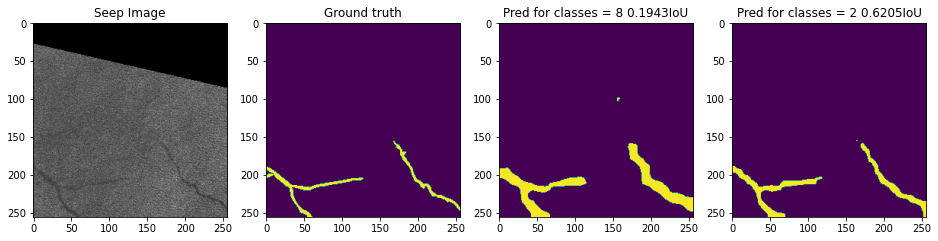




Sample 1


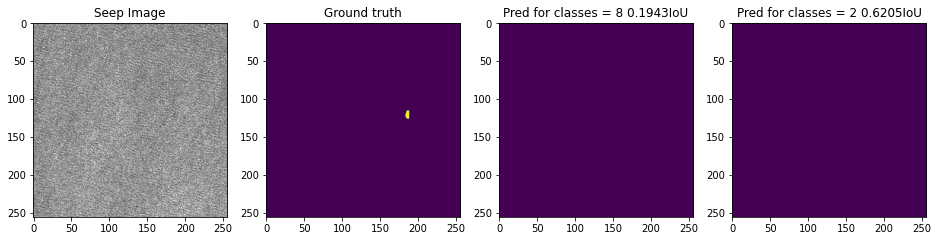




Sample 2


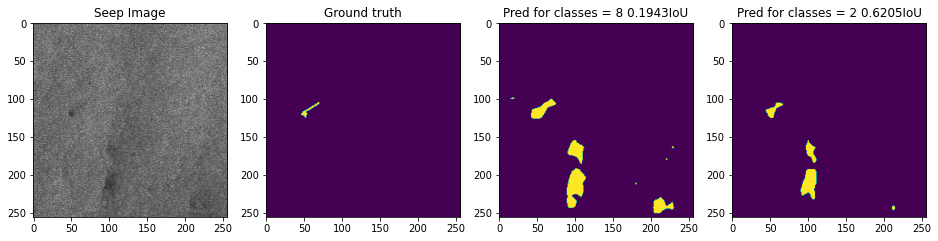




Sample 3


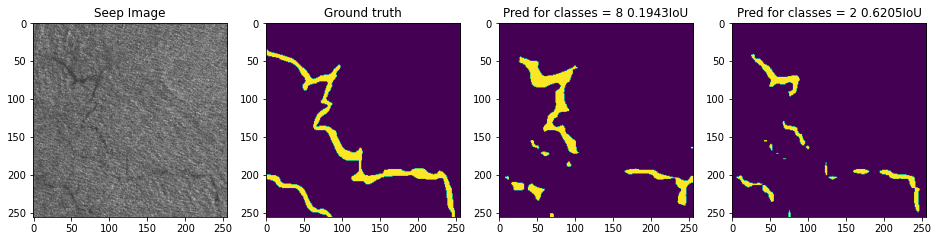




Sample 4


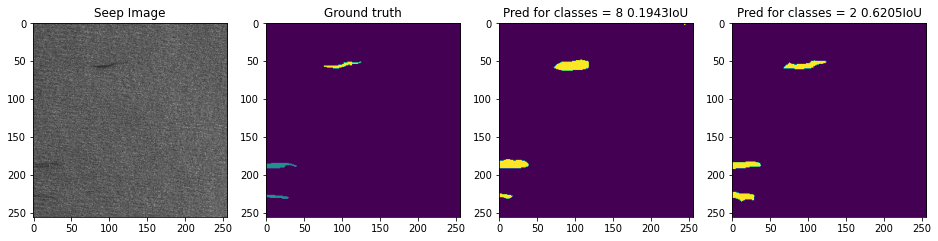




Sample 5


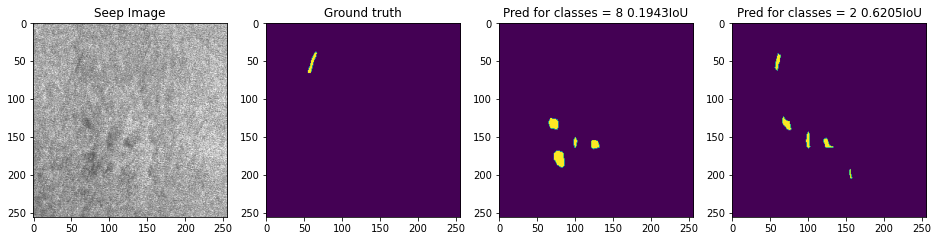




Sample 6


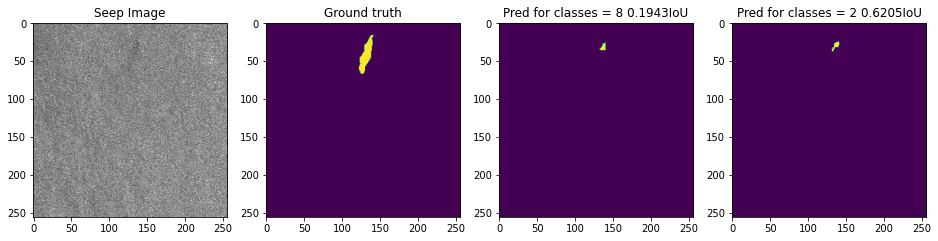




Sample 7


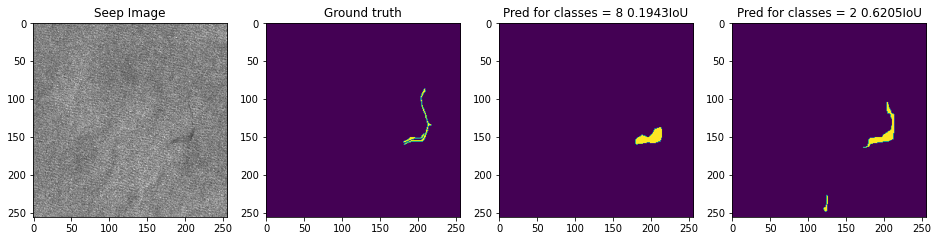




Sample 8


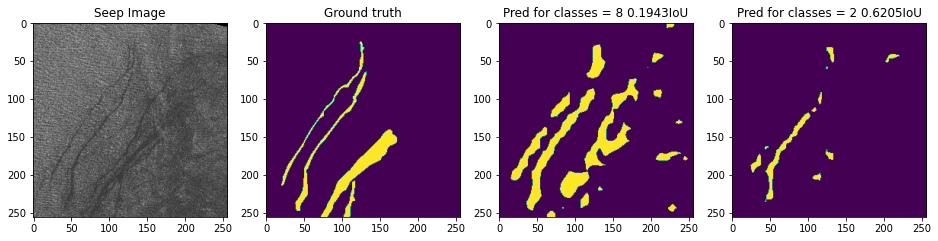




Sample 9


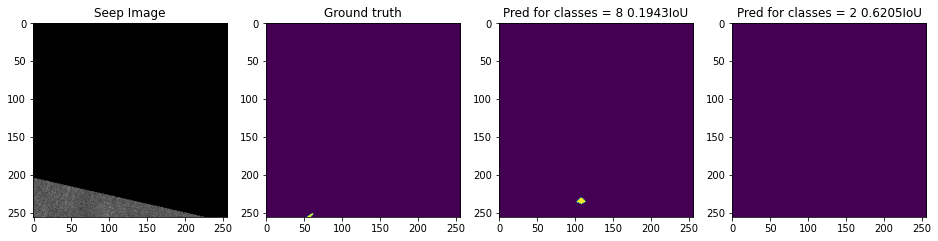




Sample 10


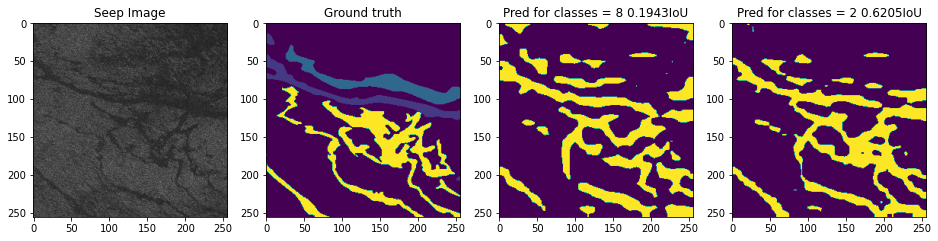




Sample 11


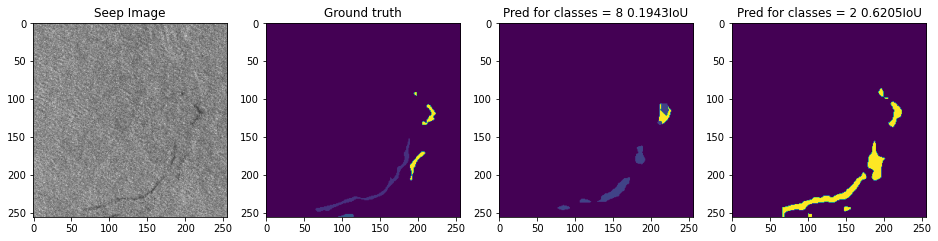




Sample 12


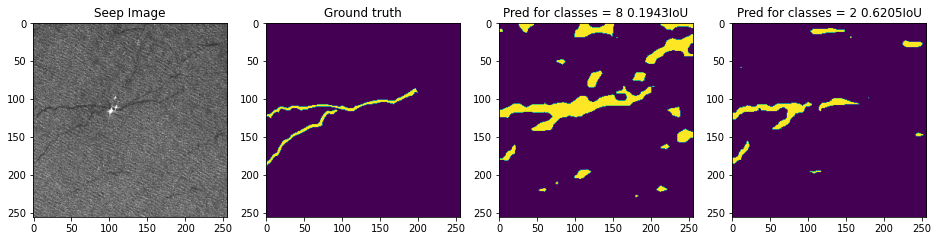




Sample 13


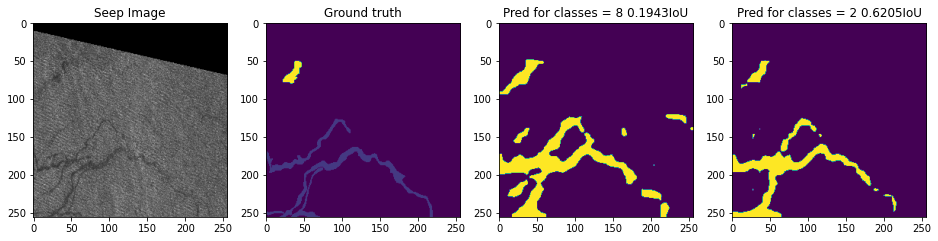




Sample 14


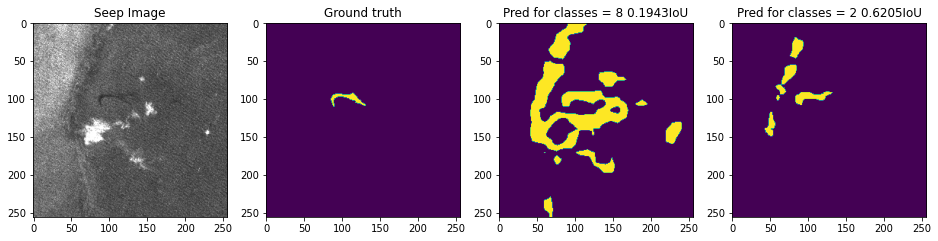




Sample 15


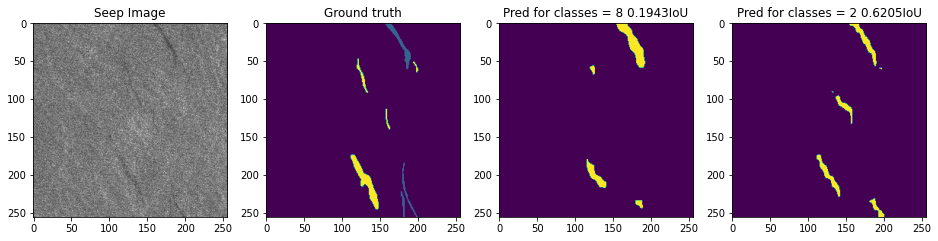

In [50]:
with torch.no_grad():
    output = model(inputs)
    output2 = model2(inputs)
    _,pred = torch.max(output['out'].data,1)
    iou = mIOU(labels,output['out'])
    _,pred2 = torch.max(output2['out'].data,1)
    iou2 = mIOU(labels,output2['out'],2)
    for idx in range(batch_size):
        print("\n\n\nSample {}".format(idx))
        plot_test_mask(inputs[idx].permute(1,2,0).cpu().detach().numpy(), labels[idx], pred[idx].cpu().detach().numpy(),
                       pred2[idx].cpu().detach().numpy(),iou=iou,iou2=iou2)

In [ ]:
#End